# Pre Test set

x is 224 and y is 224 and z is 11
(50176, 11)


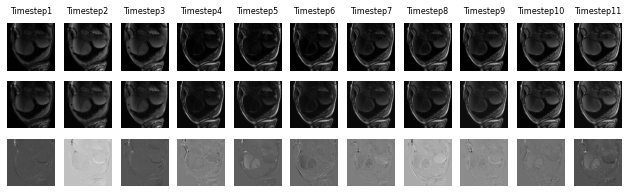

In [3]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_pre_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

### Eigenvalue percentage

In [4]:
from scripts.utils import *
orig_path = 'data/MOLLI_pre_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.7867720274668718


In [5]:
round1_path = 'results/MOLLI_pre/group/rank_5_10_20/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e100/test_MOLLI_pre/round1/moved'
r1_pca_changes = []
for file in sorted(glob.glob(os.path.join(round1_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r1_pca_changes.append(org_dis)
print(f"Mean of Orig PCA is {np.mean(np.array(r1_pca_changes))}")

Mean of Orig PCA is 0.812898820879146


### Jacobian Determination

In [6]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

folding_ratio_list = []
mag_det_jac_det_list = []
round1_path = 'results/MOLLI_pre/group/rank_5_10_20/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e100/test_MOLLI_pre/round1/warp'
for file in sorted(glob.glob(os.path.join(round1_path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    folding_ratio_list.append(folding_ratio)
    mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(mag_det_jac_det_list))}")

Mean of folding ratio is 0.0001627000231910946
Mean of mag det jac det is 0.008251510560512543


## T1 Map

### Original T1 map

Mean of t1err is 10.757982940912134 and std is 5.119879359045572


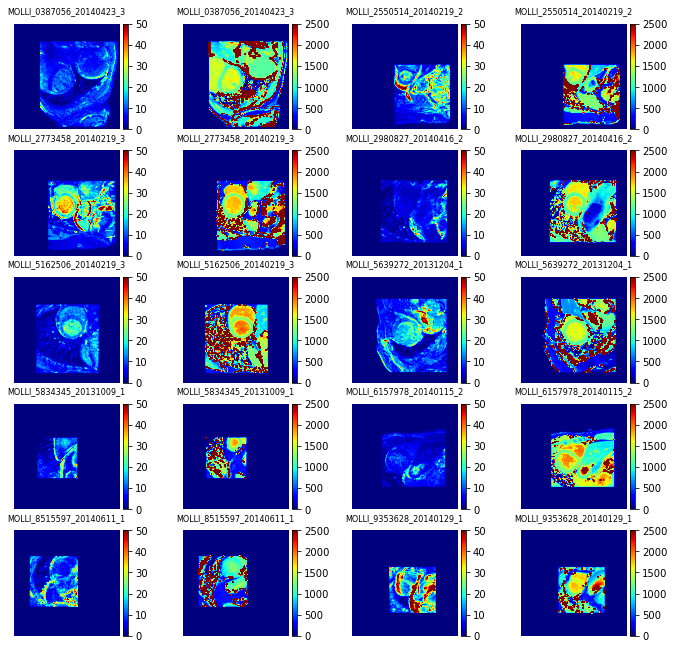

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
orig_path = 'data/MOLLI_pre_dataset/test_t1SDerr'

fig = plt.figure(figsize=(10,10))
title_font_size=8
title_pad = 10
t1err_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(orig_path, '*.mat')))):
    subject = Path(file).stem
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    errmap = SD_err * areamask

    t1err_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(5, 4, 1+i*2)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(5, 4, 2+i*2)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(t1err_list))} and std is {np.std(np.array(t1err_list))}")

### RPCA T1 Map

Mean of t1err is 9.496592375804699 and std is 4.466644333278528


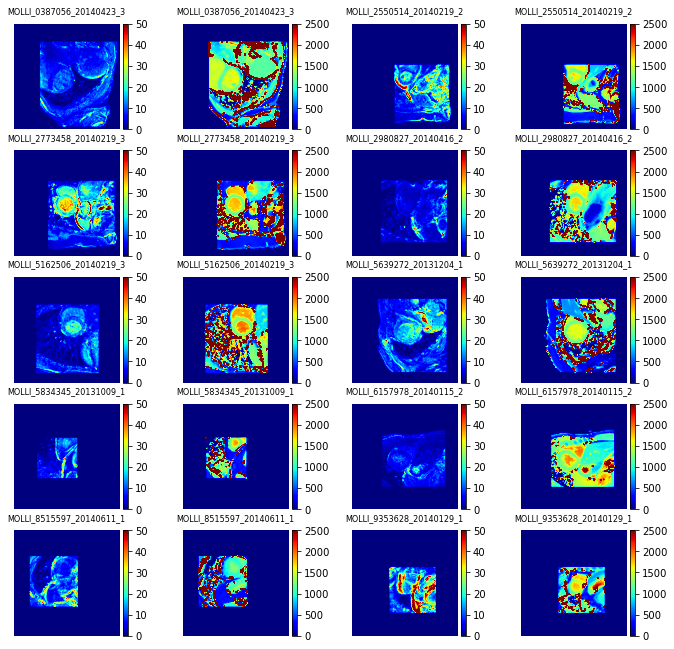

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
orig_path = 'data/MOLLI_pre_dataset/test_t1SDerr'
round1_path = 'results/MOLLI_pre/group/rank_5_10_20/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e100/test_MOLLI_pre/round1/t1SDerr'
fig = plt.figure(figsize=(10,10))
title_font_size=8
title_pad = 10
round1_t1err_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(round1_path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    orig_fd = scipy.io.loadmat(os.path.join(orig_path, f"{subject}.mat"))
    SD_err = fd['S']
    areamask = orig_fd['areamask']
    errmap = SD_err * areamask

    round1_t1err_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(5, 4, 1+i*2)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(5, 4, 2+i*2)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(round1_t1err_list))} and std is {np.std(np.array(round1_t1err_list))}")

In [20]:
import pandas as pd
col = ['Cases', 'Raw PCA', 'Rig PCA', 'Raw T1err', 'Rig T1err', 'PCA diff', 'T1err diff', 'Det', 'Fold ratio']
df = pd.DataFrame(columns=col)
df['Cases'] = subject_list
df['Raw PCA'] = orig_pca_changes
df['Rig PCA'] = r1_pca_changes
df['PCA diff'] = (df['Rig PCA'] - df['Raw PCA']) / df['Raw PCA']
df['Raw T1err'] = t1err_list
df['Rig T1err'] = round1_t1err_list
df['T1err diff'] = (df['Raw T1err'] - df['Rig T1err']) / df['Raw T1err']
df['Det'] = mag_det_jac_det_list
df['Fold ratio'] = folding_ratio_list
df

,Cases,Raw PCA,Rig PCA,Raw T1err,Rig T1err,PCA diff,T1err diff,Det,Fold ratio
0,MOLLI_0387056_20140423_3,0.806249,0.823910,7.009999,6.633620,0.021905,0.053692,0.008447,0.000000
1,MOLLI_2550514_20140219_2,0.792254,0.825341,12.341680,11.473713,0.041763,0.070328,0.009547,0.000060
2,MOLLI_2773458_20140219_3,0.773361,0.800911,13.796354,12.207454,0.035624,0.115168,0.007281,0.000310
3,MOLLI_2980827_20140416_2,0.813012,0.833929,6.068139,5.261146,0.025728,0.132989,0.008037,0.000545
4,MOLLI_5162506_20140219_3,0.787799,0.803715,8.021588,6.978278,0.020204,0.130063,0.006699,0.000000
5,MOLLI_5639272_20131204_1,0.773060,0.789908,11.220024,9.672475,0.021794,0.137927,0.007874,0.000000
6,MOLLI_5834345_20131009_1,0.757565,0.796700,8.997502,7.631757,0.051659,0.151792,0.009282,0.000272
7,MOLLI_6157978_20140115_2,0.839774,0.867991,4.527958,3.945758,0.033601,0.128579,0.008429,0.000000
8,MOLLI_8515597_20140611_1,0.770515,0.810222,12.070985,10.711733,0.051533,0.112605,0.010163,0.000440
9,MOLLI_9353628_20140129_1,0.754133,0.776361,23.525599,20.449991,0.029476,0.130735,0.006758,0.000000


In [21]:
df.describe()

,Raw PCA,Rig PCA,Raw T1err,Rig T1err,PCA diff,T1err diff,Det,Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.786772,0.812899,10.757983,9.496592,0.033329,0.116388,0.008252,0.000163
std,0.026789,0.026065,5.396827,4.708257,0.011796,0.030917,0.001166,0.000211
min,0.754133,0.776361,4.527958,3.945758,0.020204,0.053692,0.006699,0.000000
25%,0.771151,0.797752,7.262897,6.719784,0.022861,0.113246,0.007429,0.000000
50%,0.780580,0.806969,10.108763,8.652116,0.031538,0.129321,0.008233,0.000030
75%,0.802750,0.824983,12.274006,11.283218,0.040228,0.132425,0.009073,0.000300
max,0.839774,0.867991,23.525599,20.449991,0.051659,0.151792,0.010163,0.000545


# Post dataset

In [22]:
# generate the test dataset
import shutil

inpath = 'data/MOLLI_pre_dataset/test'
outpath = 'data/MOLLI_post_dataset/test'
trainpath = 'data/MOLLI_post_dataset/train'
os.makedirs(outpath, exist_ok=True)
for file in sorted(glob.glob(os.path.join(inpath, '*.npy'))):
    subject = Path(file).stem
    target = os.path.join(outpath, f"{subject}.npy")
    source = os.path.join(trainpath, f"{subject}.npy")
    shutil.copyfile(source, target)

x is 224 and y is 224 and z is 11
(50176, 11)


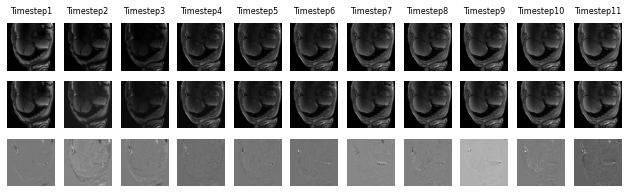

In [23]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_post_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

### Eigenvalue percentage

In [24]:
from scripts.utils import *
orig_path = 'data/MOLLI_post_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.8590354716904918
